<a href="https://colab.research.google.com/github/johanjan/MOOC-HPFEM-source/blob/master/exc_inh_network_oscillations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Oscillations in the STN-GPe subnetwork of Basal ganglia

To understand how a network of inhinbitory and excitatory neurons can generate oscilltions we will take the example of a model the oscillations observed in the basal ganglia. In Parkinson's disease, loss of dopamine alters some properties of spiking activity in the striatum leads to oscillations in the subthalamic nuclues (STN) and Globus Pallidus externa (GPE). STN is a network of excitatory neurons while GPE is a population of inhihibitory neurons.
<img src="Figures/str_gpe_stn.png">


## <font color='green'>Aims of the tutorial </font>
- Simulate a model of STN-GPE network
- Investigate the conditions under which oscillations arise
## <font color='green'>Learning outcomes</font>
- An understanding of the origin of oscillations
- A basic understanding of simulation of networks in NEST
- An understanding of oscillatory activity of neurons in a network
## <font color='green'>What will you do</font>
- Execute the Python code and display the results and describe your observations
- Write small code snippetes to perform certain simulations or calculations

## <font color='green'>Oscillations in a network of excitatory and inhibitory neurons: Heuristics</font>
<img src="./Figures/oscillation_sign_rule.png">

#### The oscillation sign rule works in the following manner:
#### Lets call the excitatory population as +, and excitatory input as +
#### Lets call the inhibitory population as -, and inhibitory input as -
#### Now to know if a particular input will enhance or supress oscillations we need to multiply the sign of neuron population and its input
#### e.g. excitation of excitatory neurons will increase oscillations but inhibition of excitatory neurons wil lead to reduction in oscillations
#### We will us this heuristics (derived from Lotka-Volterra model) to study how excitation and inibition affect oscillations.

# Betaband oscillations in the STN-GPe subnetworks of Basal ganglia

There are two key mechanisms by STN-GPE can enter into state of oscillations.
1. The connectivity between STN and GPE is increased such that the inhibition within GPE is greater than the effective excitation from STN
You can simulate this by changign the synapses:

-- j_stn_gpe = 1.2 # connection from STN to GPE

---j_gpe_stn = -1.13 5# connection from GPE to STN

Both have to be increased to create oscillations


2. Another possibility is that GPE is over inhibited by the striatum. The theory suggests that inhibition of inhibitory neurons or excitation of excitatory neurons will lead to oscillations. By contrast excitation of inhibitory neurons or inhibitio of excitatory neurons will stop or weaken oscillations
You can simulate this by changing the parameters:

-- poi_rate_bkg_gpe -> increase will reduce oscillations

-- poi_rate_bkg_stn -> increase will enhance oscillations

-- poi_rate_bkg_str -> increase will enhance oscillations


** Reference 

- Kumar A, Cardanobile S, Rotter S and Aertsen A (2011) The role of inhibition in generating and controlling Parkinson’s disease oscillations in the basal ganglia. Front. Syst. Neurosci. 5:86. doi: 10.3389/fnsys.2011.00086
- Holgado, A. J. N., Terry, J. R., and Bogacz, R. (2010). Conditions for the generation of beta oscillations in the subthalamic nucleus-globus pallidus network. J. Neurosci. 30, 12340–12352.
- Terman, D., Rubin, J. E., Yew, A. C., and Wilson, C. J. (2002). Activity patterns in a model for the subthalamopallidal network of the basal ganglia. J. Neurosci. 22, 2963–2976.


### Some preliminaries

In [ ]:
from scipy.optimize import fsolve
import numpy as np
from numpy import exp
import time
import pylab as plt
import matplotlib as matplt
%matplotlib inline

import nest

In [ ]:
# Simulation parameters
dt = 0.1    # the resolution in ms
delay = 1.5    # synaptic delay in ms

nest.ResetKernel()
nest.SetKernelStatus({"resolution": dt, "print_time": True,
                      "overwrite_files": True})

### STN-GPE Network: default parameters

In [ ]:
simtime = 1500. # Simulation Duration

# Size of the GPE and STN
Ngpe = 2000 # Number of GPE Neurons
Nstn = 1000 # Number of STN Neurons

# Input to different populations

poi_rate_bkg_gpe = 1500. # will give a baseline of ~45 Hz
poi_rate_bkg_stn = 1400. # will give a baseline of ~15 Hz
poi_rate_bkg_str = 500. # will generate oscillations
poi_rate_dbs = 500. # will quench oscillations

# Connectivity
cp_stn_stn = 0.02
cp_stn_gpe = 0.02
cp_gpe_stn = 0.02
cp_gpe_gpe = 0.02

# Weights
j_stn_stn = 1.2 # == 1.3mV at -70
j_stn_gpe = 1.2 # == 1.3mV at -70
j_gpe_gpe = -0.725 # == 0.45mV at -55
j_gpe_stn = -1.135 # == -0.7mV at -55

# delays
del_stn_stn = 2.
del_stn_gpe = 5.
del_gpe_gpe = 2.
del_gpe_stn = 5.

### Parameters describing the global synchrony and balance
-- By varying these parameters we can modulate synchrony and oscillations

In [ ]:
poi_rate_bkg_gpe = 1600. # will give a baseline of ~45 Hz
poi_rate_bkg_stn = 1400. # will give a baseline of ~15 Hz
poi_rate_bkg_str = 2000. # will generate oscillations
poi_rate_dbs = 500. # will quench oscillations

# Weights
j_stn_stn = 1.2 # == 1.3mV at -70
j_stn_gpe = 1.2 # == 1.3mV at -70
j_gpe_gpe = -0.725 # == 0.45mV at -55
j_gpe_stn = -1.135 # == -0.7mV at -55

### Create Neurons with conductance based synapses

In [ ]:
neuron_param = {'V_th':-54.0, 
                'V_reset': -70.0, 
                't_ref': 5.0, 
                'g_L':10.0,
                'C_m':200.0, 
                'E_ex': 0.0, 
                'E_in': -80.0, 
                'tau_syn_ex':5.0,
                'tau_syn_in': 10.0,
                'tau_minus':20.0}
gp_neurons = nest.Create('iaf_cond_exp',Ngpe,neuron_param)
st_neurons = nest.Create('iaf_cond_exp',Nstn,neuron_param)

### Connect the neurons to spike detectors

In [ ]:
# Spike detectors
gp_sd = nest.Create("spike_detector", 1)
st_sd = nest.Create("spike_detector", 1)
nest.SetStatus(gp_sd,[{"label": "GPE",
                       "withtime": True,
                       "withgid": True,
                       "to_file": True}])
nest.SetStatus(st_sd,[{"label": "STN",
                       "withtime": True,
                       "withgid": True,
                       "to_file": True}])

print("Connecting devices")
# record spikes

nest.Connect(gp_neurons,gp_sd)
nest.Connect(st_neurons,st_sd)

Connecting devices


### Connect external input to the STN and GPE neurons

In [ ]:
nest.CopyModel("static_synapse", "poi_excitatory",
               {"weight": 1.0, "delay": 1.0})
#PG to GPE
pg_gen_gpe = nest.Create('poisson_generator',1,{'rate':poi_rate_bkg_gpe})
nest.Connect(pg_gen_gpe,gp_neurons,syn_spec="poi_excitatory")
# PG TO STN
pg_gen_stn = nest.Create('poisson_generator',1,{'rate':poi_rate_bkg_stn})
nest.Connect(pg_gen_stn,st_neurons,syn_spec="poi_excitatory")

### Simulate PD by increasing Striatum firing rates
(Striatum input is switched on at 500ms)

In [ ]:
nest.CopyModel("static_synapse", "poi_inhibitory",
               {"weight": -1.0, "delay": 1.0})
pg_gen_str = nest.Create('poisson_generator',1,{'rate':poi_rate_bkg_str, 'start':500.,'stop':3000.})
print ("Connecting Striatum -- PD Condition")
#PG to GPE
nest.Connect(pg_gen_str,gp_neurons,syn_spec="poi_inhibitory")


Connecting Striatum -- PD Condition


### Connect STN and GPE neurons

In [ ]:
syn_stn_stn = int(Nstn*cp_stn_stn)   
syn_stn_gpe = int(Ngpe*cp_stn_gpe)
syn_gpe_gpe = int(Ngpe*cp_gpe_gpe)
syn_gpe_stn = int(Nstn*cp_gpe_stn)

conn_dict_stn2stn = {"rule": "fixed_indegree", "indegree": syn_stn_stn}
conn_dict_stn2gpe = {"rule": "fixed_indegree", "indegree": syn_stn_gpe}
conn_dict_gpe2stn = {"rule": "fixed_indegree", "indegree": syn_gpe_stn}
conn_dict_gpe2gpe = {"rule": "fixed_indegree", "indegree": syn_gpe_gpe}

syn_dict_stn2stn = {"delay": del_stn_gpe, "weight": j_stn_stn}
syn_dict_stn2gpe = {"delay": del_stn_gpe, "weight": j_stn_gpe}
syn_dict_gpe2stn = {"delay": del_gpe_stn, "weight": j_gpe_stn}
syn_dict_gpe2gpe = {"delay": del_gpe_gpe, "weight": j_gpe_gpe}

print ('STN GPE Connect')
# random connectivity, synapse numbers
print (syn_stn_stn)
print (syn_stn_gpe)
print (syn_gpe_gpe)
print (syn_gpe_stn)
# STN-STN == No connections
print ('Connect STN-STN')
#nest.Connect(st_neurons,st_neurons,conn_dict_stn2stn, syn_dict_stn2stn)
print ('Connect STN-GPE')
nest.Connect(st_neurons,gp_neurons,conn_dict_stn2gpe, syn_dict_stn2gpe)
print ('Connect GPE-STN')
nest.Connect(gp_neurons,st_neurons,conn_dict_gpe2stn, syn_dict_gpe2stn)
print ('Connect GPE-GPE')
nest.Connect(gp_neurons,gp_neurons,conn_dict_gpe2gpe, syn_dict_gpe2gpe)

STN GPE Connect
20
40
40
20
Connect STN-STN
Connect STN-GPE
Connect GPE-STN
Connect GPE-GPE


### Simulate

In [ ]:
print("Simulating")
nest.Simulate(simtime)

Simulating


### Read and plot the spiking activity

In [ ]:
xx_stn = np.loadtxt('STN-3002-0.gdf')
xx_gpe = np.loadtxt('GPE-3001-0.gdf')

bin_size = 5
ed = np.arange(0,simtime,bin_size)
hh_stn,edx = np.histogram(xx_stn[:,1],ed)
hh_stn = hh_stn/(bin_size*1e-3)/np.float(Nstn)

hh_gpe,edx = np.histogram(xx_gpe[:,1],ed)
hh_gpe = hh_gpe/(bin_size*1e-3)/np.float(Ngpe)

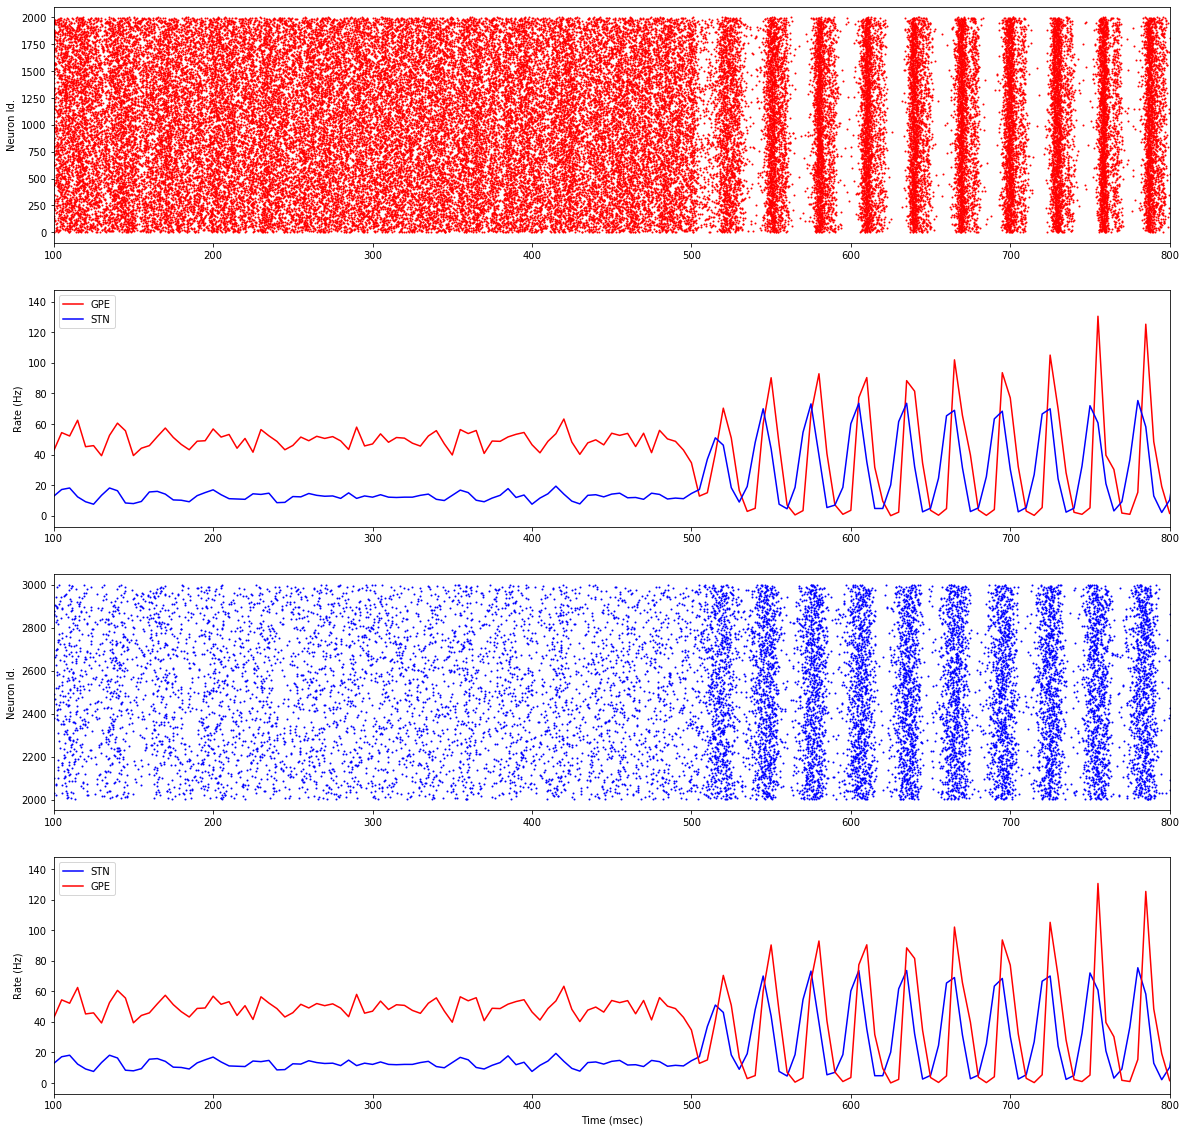

In [ ]:
x_lim = [100,800]
plt.figure(figsize=(20, 20))
plt.subplot(4,1,1)
plt.plot(xx_gpe[:,1],xx_gpe[:,0],'.',ms=2,color='r')
plt.xlim(x_lim)
plt.ylabel('Neuron Id.')

plt.subplot(4,1,2)
plt.plot(ed[:-1],hh_gpe,color='r',label='GPE')
plt.plot(ed[:-1],hh_stn,color='b',label='STN')
plt.ylabel('Rate (Hz)')
plt.legend()
plt.xlim(x_lim)

plt.subplot(4,1,3)
plt.plot(xx_stn[:,1],xx_stn[:,0],'.',ms=2,color='b')
plt.xlim(x_lim)

#plt.xlabel('Time (msec)')
plt.ylabel('Neuron Id.')

plt.subplot(4,1,4)
plt.plot(ed[:-1],hh_stn,color='b',label='STN')
plt.plot(ed[:-1],hh_gpe,color='r',label='GPE')
plt.legend()
plt.xlim(x_lim)
plt.xlabel('Time (msec)')
plt.ylabel('Rate (Hz)')

plt.show()

# <font color=green>STN GPe Oscillations</font>
### In the first we simulate the network with no input from the striatum for first 500ms. At 500ms we inhibit the GPE by increasing the firing rate of the striatal neurons. As soon as the striatum starts to inhibit the inhibitory neurons of GPe, oscillations gets going.

# <font color=blue>Describe</font>
### Could you come up with a series of events that take place as we inhibit GPe neurons leading into stable oscillations. 
### Why the STN leads the oscillations? Maybe that gives you a clue to answer the previous question


# <font color=salmon>TO DO</font>
- Vary the parameters 
-- poi_rate_bkg_gpe, poi_rate_bkg_stn = 1400, poi_rate_bkg_str 
and study their effect of the oscillations. <br>
Essentially check the oscillation rule dscribed above
- How will you estimate the frequency of oscillations and if there are oscillations at all? <br>
<font color=gray>An easy way to estimate frequency of oscillations is to counr the cycles -- not really. The correct way is to estimate the Fourier Transform (or spectrum) of the population activity. Go to stackoverflow and find out how spectrum can be estimated</font>
- Once you have estimated the power spectrum using Fourier Transform you can use the following formulae to estimate what we call as the spectral entropy. When SE is zero you have pure oscillations and when it appraoches one you have weak or no oscillations
```python
 pxx_norm = pxx/sum(pxx)
 se = -xx_norm*np.log(pxx_norm).T
```python

# <font color=salmon>TO DO</font>
### Simulate DBS by inhbiting STN
- If you want to check what will happen to oscillations if you excited the excitatory population (STN) use the following snippet
- Also you may want to try what happens when GPE is inhibited and STN is excited or 
- GPE is inhibited and STN is excited -- this will be like mimicking deep brain stimulation treatment of PD patients
```python
pg_gen_dbs = nest.Create('poisson_generator',1,{'rate':poi_rate_dbs, 'start':1500.,'stop':2500.})
if connect_stn_dbs:
    print ('Connecting STN Inhibition -- DBS Condition')
    #PG to STN
    nest.Connect(pg_gen_dbs,st_neurons,syn_spec="poi_excitatory")
```python